# Задание 1. A/B-тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов.
Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена
новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика.
В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, 
стоит ли запускать новую механику оплаты на всех пользователей.

## 1.1 Импорт библиотек

In [12]:
import pandas as pd
import numpy as np
import urllib.parse
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import plotly.express as px
%matplotlib inline

from scipy.stats import norm
import scipy.stats as stats

from tqdm.auto import tqdm

## 1.2 Загрузка данных

In [13]:
# загрузка данных из Яндекс.Диск
url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
pub_key_1 = 'https://yadi.sk/d/UhyYx41rTt3clQ'  
pub_key_2 = 'https://yadi.sk/d/5Kxrz02m3IBUwQ' 
pub_key_3 = 'https://yadi.sk/d/Tbs44Bm6H_FwFQ' 
pub_key_4 = 'https://yadi.sk/d/pH1q-VqcxXjsVA' 

ready_url_1 = url + urllib.parse.urlencode(dict(public_key=pub_key_1)) 
response = requests.get(ready_url_1) 
download_url_1 = response.json()['href'] 

ready_url_2 = url + urllib.parse.urlencode(dict(public_key=pub_key_2)) 
response = requests.get(ready_url_2) 
download_url_2 = response.json()['href'] 

ready_url_3 = url + urllib.parse.urlencode(dict(public_key=pub_key_3)) 
response = requests.get(ready_url_3) 
download_url_3 = response.json()['href'] 

ready_url_4 = url + urllib.parse.urlencode(dict(public_key=pub_key_4)) 
response = requests.get(ready_url_4) 
download_url_4 = response.json()['href'] 



# загрузка данных в пандасовские датафреймы

# файл с информацией о принадлежности пользователей 
# к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups = pd.read_csv(download_url_1, sep=';')

# дополнительный файл с информацией о пользователях, который прислали 2 дня спустя
groups_add = pd.read_csv(download_url_2, sep=',')

#  файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
active_studs = pd.read_csv(download_url_3, sep=';')

# файл с информацией об оплатах пользователей в дни проведения эксперимента
checks = pd.read_csv(download_url_4, sep = ';')

In [14]:
# переименуем student_id в id для удобства
active_studs = active_studs.rename(columns={'student_id': 'id'})
checks = checks.rename(columns={'student_id': 'id'})

## 1.3 Предобработка данных для статистических тестов

In [15]:
# Смержим groups и active_studs. То есть тех, кто попал в эксперимент и посетил платформу во время эксперимента.
union_active_groups = active_studs.merge(groups, how='inner', on='id')

In [16]:
union_active_groups.shape

(8328, 2)

In [17]:
# Посмотрим количество пользователей в группах по отдельности.
union_active_groups_ab = union_active_groups.groupby('grp', as_index=False).agg({'id': 'count'})
union_active_groups_ab

,grp,id
0,A,1535
1,B,6793


In [18]:
# Смержим union_active_groups и checks
union_active_checks = union_active_groups.merge(checks, how='left', on='id')

In [19]:
# в столбце rev заменим все NaN на нули 
union_active_checks['rev'] = union_active_checks['rev'].fillna(0)

In [20]:
# получили датасет с информацией об активных студентах, которые заходили на сайт во время эксперимента, 
# при этом часть из них (rev > 0) в тестовой группе (В) увидели и воспользовались новой механикой оплаты
union_active_checks.head()

,id,grp,rev
0,581585,A,0.0
1,3276743,B,0.0
2,4238589,A,0.0
3,4475369,B,0.0
4,5481015,B,0.0


In [21]:
union_active_checks.shape

(8328, 3)

In [22]:
union_active_checks.query('rev > 0').shape

(391, 3)

Здесь нужно ввести оговорку.
У нас в итоговом датасете union_active_checks вышло 391 заплативших студентов из обеих групп, в то время как в датасете checks, заплативших насчитывалось 541 человек. Объясняю эту разницу тем, что могла быть оплата с другой платформы или в данных произошла ошибка. Поэтому необходимо было оставить только посетивших сайт платников, потому как не посещавшие сайт пользователи не могли увидеть новую механику оплаты.

In [23]:
# посмотрим на количество студентов по группам А и В
union_active_checks_ab = union_active_checks.groupby('grp', as_index=False).agg({'id': 'count'})
union_active_checks_ab

,grp,id
0,A,1535
1,B,6793


In [24]:
# посмотрим основные статистики среди заплативших в обеих группах
df_only_check = union_active_checks.query('rev != 0')

df_only_check[['rev', 'grp']].groupby(['grp']).describe()

rev                                                                
     count         mean         std    min    25%     50%      75%     max
grp                                                                       
A     78.0   933.589744  919.932711  199.0  290.0   585.0  1114.75  3660.0
B    313.0  1255.827487  791.293377  199.0  489.0  1140.0  1900.00  4650.0

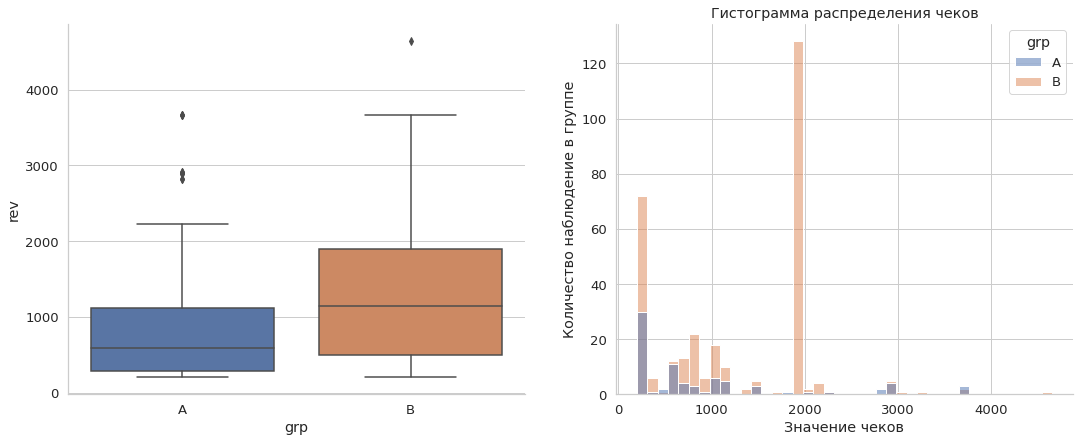

In [25]:
# Визуализируем приведенные выше статистики 
ax = sns.set(font_scale=1.2, style="whitegrid", rc={'figure.figsize': (18, 15)})
plt.subplot(221)
sns.boxplot(x='grp', y='rev', data=df_only_check)
sns.despine()

plt.subplot(222)
ax = sns.histplot(data=df_only_check, x='rev', hue='grp', bins=40)
ax.set_xlabel('Значение чеков')
ax.set_ylabel('Количество наблюдение в группе')
ax.set_title('Гистограмма распределения чеков')
sns.despine()

На диаграмме с боксплотами можно наблюдать выбросы в обеих группах. В тестовой группе видно более высокое медианное значение чеков и бОльший межквартельный размах. Распределения в обеих группах имеют явно не нормальное распределение, скошенное в левую сторону (проверять распределения на нормальность тестом Шапиро-Уилка не имеет смысла). 
Стоит присмотреться к чекам в тестовой группе (В), т.к. там большое количество чеков приходится на одно фиксированное значение.

In [26]:
# здесь мы видим большое количество чеков по 1900.
df_only_check[df_only_check.grp == 'B'].rev.round(0).value_counts().head(10)

1900.0    127
290.0      45
199.0      27
840.0      21
990.0      17
690.0      13
1140.0      9
398.0       6
590.0       6
580.0       5
Name: rev, dtype: int64

Обе группы содержат много повторяющихся значений. Можно наблюдать значительную часть оплат с чеком 1900 (127 пользователей). 
Такой характер чеков в группах может говорить об абонетской плате на сайте (подписочный сервис) или об акции, проходящей в дни проведения эксперимента.

## 1.4 Определение метрик

Определимся с метриками, по которые будем отслеживать в эксперименте.
В нашем сервисе была предложена новая механика оплаты услуг на сайте, значит это повлияет на **конверсию в покупку** (СR). Именно эту метрику сделаем целевой в нашем эксперименте.

Сопутствующей метрикой будет **средний чек** (AOV). Важно прослежить, чтобы эта метрика не снижалась.

## 1.5 Расчет метрик

In [27]:
# агрегируем метрики в одном датасете по граппам А и В
metrics_df = union_active_checks.groupby(['grp'], as_index=False).agg(
    converted_users = ('rev', lambda x: x[x > 0].count()),
    all_users = ('id', lambda x: len(x)),
    revenue =  ('rev', lambda x: sum(x)))

# расчитаем основную и сопутствующую метрики
metrics_df['CR'] = metrics_df['converted_users'] / metrics_df['all_users']
metrics_df['AOV'] = metrics_df['revenue'] / metrics_df['converted_users']

metrics_df

,grp,converted_users,all_users,revenue,CR,AOV
0,A,78.0,1535,72820.0000,0.050814,933.589744
1,B,313.0,6793,393074.0035,0.046077,1255.827487


## 1.6 Проверка статистической значимости целевой метрики

При сильных различиях численности групп, конверсия (CR) в контрольной и тестовой группах различаются не сильно. Чтобы проверить статистическую значимость данных различий, воспользуемся тестом Хи-квадрат, т.к. наши переменные являются категориальными.

## 1.6.1 Тест Хи-квадрат

Требования для теста Хи-квадрат:
    - Данные должны быть измерены в категориях или группах;
    - Объем выборки должен быть достаточно большим (обычно не менее 30 наблюдений);
    - Наблюдения должны быть независимы друг от друга;
    - Ожидаемые частоты должны быть не менее 5 для каждой ячейки таблицы сопряженности.

In [28]:
# из таблицы metrics_df возьмем нужные столбцы, чтобы получилась таблица сопряженности
crosstab = metrics_df[['grp', 'all_users', 'converted_users']].set_index('grp')
crosstab

,all_users,converted_users
grp,,
A,1535,78.0
B,6793,313.0


In [29]:
arr = np.array([[crosstab['all_users'][0], crosstab['converted_users'][0]], 
                [crosstab['all_users'][1], crosstab['converted_users'][1]]])

Нулевая гипотеза (**H0**): Разницы между конверсией в покупку в тестовой и контрольной группе нет.

Альтернативная гипотеза (**H1**): Разница между конверсией в покупку в тестовой и контрольной группе есть.

С помощью statsmodels получим значение статистики и p-value.
Уровень значимости: α = 0.05

In [30]:
chi2 = stats.chi2_contingency(arr)

print(f'p-value: {round(chi2[1], 2)}')

p-value: 0.49


ВЫВОД:
По результатам теста p-value = 0.49, при пороговом значении 0.05. Таким образом, мы не имеем достаточных оснований, чтобы не отклонять нулевую гипотизу. В данном случае, падение конверсии в тестовой группе статистически  не значимо.

## 1.7 Проверка статистичемской значимости сопутствующей метрики

Ранее уже отмечали, что чеки в контрольной и тестовой группах распределены не нормальным образом и с выбросами в данных. Таким образом, для оценки отличий в группах сравнивать среднее и медианы в t-test не рекомендуется.  
Критерий mann-whitney также не стоит рассматривать, т.к. имеется большое количество повторяющихся значений и сам критерий проверяет гипотизу о равенстве рангов в группах. Будем использовать Бутстрап.

## 1.7.1 Бутсрап

Проверим среднее значение в контрольной и тестовой группах на статзначимость.

**H0**: разницы между средними значениями среднего чека двух групп нет;

**H1**: разница между средними значениями есть.

In [31]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    sns.set(font_scale=1.2, style="whitegrid", rc={'figure.figsize': (9, 6)})
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('seagreen')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [32]:
# отберем числовые значения контрольной и тестовой групп
sample_1 = df_only_check[df_only_check.grp == 'A'].rev
sample_2 = df_only_check[df_only_check.grp == 'B'].rev

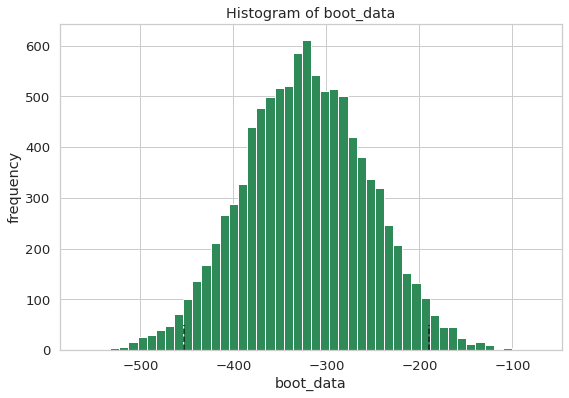

1.971565883047141e-06

In [33]:
booted_data = get_bootstrap(sample_1, sample_2) # в результате хранится разница двух распределений, ДИ и pvalue
booted_data['p_value']

В получишемся Бутстрап-распределении p-value < 0,05 и 0 не входит в доверительный интервал. Можем сделать вывод, что средний чек по оценке средних в двух группах статистически отличается.

## Вывод:

- Тестируя конверсию в покупку мы не смогли отклонить H0, примененный нами тест Хи-квадрат показал отсутствие различий между конверсиями в тестовой и контрольной группах;
- Средний чек: примененный Бутстрам показал статистически значимое различие в проверке среднего чека;
- Новая механика оплаты на сайте не повлияла на изменение целевой метрики, но было зафиксировано повышение среднего чека. Имея такие результаты эксперимента, можно заключить, что вводить новую механику оплаты не рекомендуется, т.к. на повышение среднего чека могли повлиять другие факторы.
- Повышение среднего чека могло быть связано с акциями или рекомендуемыми товарами внутри корзины или параллельно запущенные эксперименты с внедрением новых фич на сайте. Особое внимание хочется уделить большому количеству чеков в размере 1900 в тестовой группе. Этот момент следует изучить глубже.

# Задание 2. Функции

## 2.1 Функция пересчета метрик

In [34]:
def recalculation(groups, groups_add, active_studs, checks):
    """соединение основного источника данных с дополнительным и пересчет основных метрик на основании доп. данных"""
    data_concat = pd.concat([groups, groups_add], ignore_index=True)
    
    # меняем название столбцов, чтобы было по единому образцу во всех датафреймах
    active_studs.rename(columns={'student_id' : 'id'}, inplace=True)
    checks.rename(columns={'student_id' : 'id'}, inplace=True)
   
    # получаем пользователей, которые заходили на платформу во время эксперимента
    union_active_groups = active_studs.merge(data_concat, how='inner', on='id')
    union_active_checks = union_active_groups.merge(checks, how='left', on='id')
    union_active_checks['rev'] = union_active_checks['rev'].fillna(0)

    # считаем основные метрики
    metrics_df = union_active_checks.groupby(['grp'], as_index=False).agg(
    converted_users = ('rev', lambda x: x[x > 0].count()),
    all_users = ('id', lambda x: len(x)),
    revenue =  ('rev', lambda x: sum(x)))

    metrics_df['CR'] = metrics_df['converted_users'] / metrics_df['all_users']
    metrics_df['AOV'] = metrics_df['revenue'] / metrics_df['converted_users']
    
    return metrics_df

In [35]:
recalculation(groups, groups_add, active_studs, checks)

,grp,converted_users,all_users,revenue,CR,AOV
0,A,78.0,1538,72820.0000,0.050715,933.589744
1,B,314.0,6803,394974.0035,0.046156,1257.878992


## 2.2 Функция визуализации метрик

In [36]:
def viz_metrics(metrics_df):
    """визуализируем полученные метрики"""
    sns.set(font_scale=1.2, style="whitegrid", rc={'figure.figsize': (20, 15)})
    plt.subplot(221)
    plt.title('Конверсия в покупку')
    sns.barplot(data=metrics_df, x='grp', y='CR',  palette='pastel')
    plt.subplot(222)
    plt.title('Средний чек')
    sns.barplot(data=metrics_df, x='grp', y='AOV', palette='pastel')

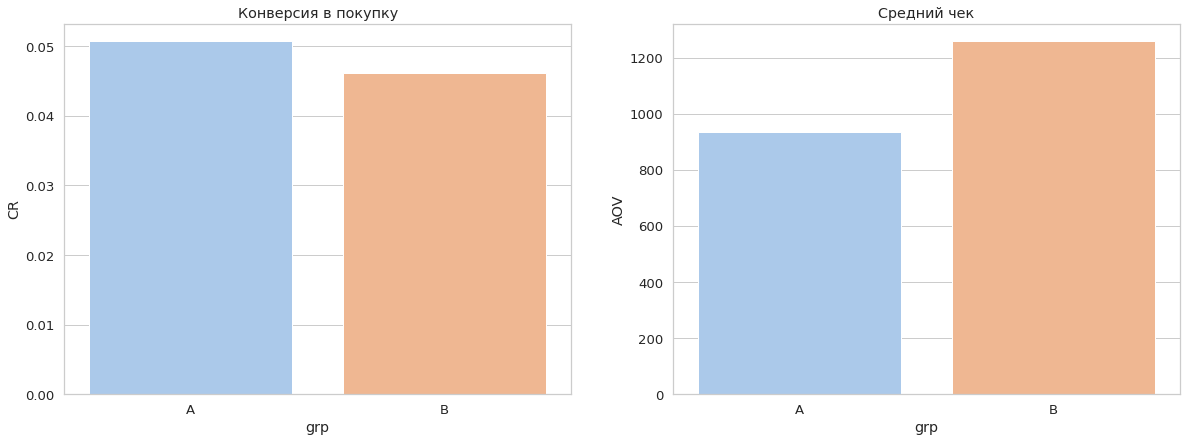

In [37]:
viz_metrics(recalculation(groups, groups_add, active_studs, checks))